In [1]:
import javalang
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV


def get_mth(class_declaration: javalang.tree.ClassDeclaration) -> int:
    return len(class_declaration.methods)

def get_fld(class_declaration: javalang.tree.ClassDeclaration) -> int:
    return len(class_declaration.fields)

def get_rfc(class_declaration: javalang.tree.ClassDeclaration) -> int:
    num_public_methods = 0
    invoked_methods = 0
    for method in class_declaration.methods:
        if 'public' in method.modifiers:
            num_public_methods += 1
    for _,method_invocation in class_declaration.filter(javalang.tree.MethodInvocation):
        invoked_methods += 1
    return num_public_methods + invoked_methods

def get_interfaces(class_declaration: javalang.tree.ClassDeclaration) -> int:
    count = 0
    for i,j, in class_declaration.filter(javalang.tree.InterfaceDeclaration):
        count += 1
    return count

def get_ex(class_declaration: javalang.tree.ClassDeclaration) -> int:
    num_exceptions = 0
    for _,throws in class_declaration.filter(javalang.tree.ThrowStatement):
        num_exceptions += 1
    return num_exceptions

def get_ret(class_declaration: javalang.tree.ClassDeclaration) -> int:
    num_return = 0
    for _,s in class_declaration.filter(javalang.tree.ReturnStatement):
        num_return += 1
    return num_return

def get_bcm_wrd(class_declaration: javalang.tree.ClassDeclaration) -> int:
    blocks = 0
    num_words = 0
    for _,j in class_declaration:
        try:
            if j.documentation is not None:
                blocks += 1
                num_words += len(j.documentation.split())
        except:
            pass
    return blocks, num_words
    
def get_nml(class_declaration: javalang.tree.ClassDeclaration) -> int:
    ''' average length of method names'''
    num_methods = 0.0
    count = 0.0
    for _,method in class_declaration.filter(javalang.tree.MethodDeclaration):
        num_methods += 1
        count += len(method.name)
    return count/num_methods if num_methods > 0 else 0

def get_sz_cpx(class_declaration: javalang.tree.ClassDeclaration) -> int:
    num_statements = 0
    num_cpx = 0
    for _,statement in class_declaration.filter(javalang.tree.Statement):
        num_statements += 1
        if isinstance(statement, javalang.tree.IfStatement) or isinstance(statement, javalang.tree.WhileStatement) or isinstance(statement, javalang.tree.ForStatement) or isinstance(statement, javalang.tree.DoStatement) or isinstance(statement, javalang.tree.SwitchStatement):
            num_cpx += 1
    return num_statements, num_cpx


def get_class_metrics(class_declaration: javalang.tree.ClassDeclaration) -> dict:
    mth = get_mth(class_declaration)
    fld = get_fld(class_declaration)
    rfc = get_rfc(class_declaration)
    inter = get_interfaces(class_declaration)
    ex = get_ex(class_declaration)
    ret = get_ret(class_declaration)
    bcm, wrd = get_bcm_wrd(class_declaration)
    nml = get_nml(class_declaration)
    sz, cpx = get_sz_cpx(class_declaration)
    dcm = wrd/sz if sz > 0 else 0

    return {'mth': mth, 'fld': fld, 'rfc': rfc, 'int': inter, 'ex': ex, 'ret': ret, 'bcm': bcm, 'wrd': wrd, 'nml': nml, 'sz': sz, 'cpx': cpx, 'dcm': dcm}

def get_feature_vectors(directory_path: str, save_path = None) -> pd.DataFrame:
    df = pd.DataFrame(columns=['class_name', 'mth', 'fld', 'rfc', 'int', 'ex', 'ret', 'bcm', 'wrd', 'nml', 'sz', 'cpx', 'dcm', 'file_path'])
    for path_walk, _, files_walk in os.walk(directory_path):
        for file in files_walk:
            if file.endswith('.java'):
                with open(os.path.join(path_walk, file), 'r') as f:
                    tree = javalang.parse.parse(f.read())
                inner_classes = []
                for _,class_declaration in tree.filter(javalang.tree.ClassDeclaration):
                    name = class_declaration.name
                    if name not in inner_classes:
                        for _, inner_class in class_declaration.filter(javalang.tree.ClassDeclaration):
                            inner_classes.append(inner_class.name)
                        metrics = get_class_metrics(class_declaration)
                        idx = len(df)
                        metrics['class_name'] = name
                        metrics['file_path'] = os.path.join(path_walk, file)
                        for c in metrics.keys():
                            df.loc[idx, c] = metrics[c]
    if save_path is not None:
        df.to_csv(save_path, index=False)            
    return df

def get_buggy_classes(buggy_classes_dir_path):
    buggy_classes = []
    for path_walk, _, files_walk in os.walk(buggy_classes_dir_path):
            for file in files_walk:
                if file.endswith('.src'):
                    with open(os.path.join(path_walk, file), 'r') as f:
                        while True:
                            line = f.readline()
                            if not line:
                                break
                            else:
                                buggy_classes.append(line.split('.')[-1].strip('\n'))
    return buggy_classes

def label_feature_vectors(feature_vectors_csv_path, buggy_classes, save_path = None):
    df = pd.read_csv(feature_vectors_csv_path)
    df['buggy'] = 0
    for i in range(len(df)):
        if df.loc[i, 'class_name'] in buggy_classes:
            df.loc[i, 'buggy'] = 1
    if save_path is not None:
        df.to_csv(save_path, index=False)
    return df


In [32]:
file1 = '../testing/AnalyzePrototypeProperties.java'
file2 = '../testing/CheckPathsBetweenNodes.java'
file3 = '../testing/CodeChangeHandler.java'
file4 = '../testing/Normalize.java'


with open(file4, 'r') as f:
    tree = javalang.parse.parse(f.read())

inner_classes = []
for _,class_declaration in tree.filter(javalang.tree.ClassDeclaration):
    if class_declaration.name not in inner_classes:
        for _, inner_class in class_declaration.filter(javalang.tree.ClassDeclaration):
            inner_classes.append(inner_class.name)
        print(get_nml(class_declaration))

15.233333333333333


In [2]:
path = '../resources/defects4j-checkout-closure-1f/src/com/google/javascript/jscomp'
df = get_feature_vectors(path, save_path='../generated/class_metrics.csv')

In [3]:
df

,class_name,mth,fld,rfc,int,ex,ret,bcm,wrd,nml,sz,cpx,dcm,file_path
0,AbstractCommandLineRunner,54,19,430,0,33,103,94,2359,18.089109,740,157,3.187838,../resources/defects4j-checkout-closure-1f/src...
1,AbstractCompiler,51,2,10,0,0,4,52,1077,16.907407,5,0,215.4,../resources/defects4j-checkout-closure-1f/src...
2,AbstractMessageFormatter,5,3,8,0,0,8,2,28,13.5,13,2,2.153846,../resources/defects4j-checkout-closure-1f/src...
3,AbstractPeepholeOptimization,13,1,22,0,0,8,14,376,17.076923,24,3,15.666667,../resources/defects4j-checkout-closure-1f/src...
4,AliasExternals,16,15,205,0,1,10,36,1138,14.12,171,44,6.654971,../resources/defects4j-checkout-closure-1f/src...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,ChainableReverseAbstractInterpreter,11,6,114,0,1,90,22,696,15.486842,170,25,4.094118,../resources/defects4j-checkout-closure-1f/src...
287,ClosureReverseAbstractInterpreter,2,5,57,0,0,27,7,76,11.1,57,10,1.333333,../resources/defects4j-checkout-closure-1f/src...
288,SemanticReverseAbstractInterpreter,11,5,149,0,0,68,12,299,14.52,219,50,1.365297,../resources/defects4j-checkout-closure-1f/src...
289,AbstractWebServiceException,3,0,7,0,0,1,1,19,12.333333,1,0,19.0,../resources/defects4j-checkout-closure-1f/src...


In [4]:
buggy_classes = get_buggy_classes('../resources/modified_classes')
save_path = '../generated/class_metrics_labeled.csv'
feature_vector_csv_path = '../generated/class_metrics.csv'
df_labeled = label_feature_vectors(feature_vector_csv_path, buggy_classes, save_path = save_path)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

In [6]:
df_labeled

,class_name,mth,fld,rfc,int,ex,ret,bcm,wrd,nml,sz,cpx,dcm,file_path,buggy
0,AbstractCommandLineRunner,54,19,430,0,33,103,94,2359,18.089109,740,157,3.187838,../resources/defects4j-checkout-closure-1f/src...,1
1,AbstractCompiler,51,2,10,0,0,4,52,1077,16.907407,5,0,215.400000,../resources/defects4j-checkout-closure-1f/src...,0
2,AbstractMessageFormatter,5,3,8,0,0,8,2,28,13.500000,13,2,2.153846,../resources/defects4j-checkout-closure-1f/src...,0
3,AbstractPeepholeOptimization,13,1,22,0,0,8,14,376,17.076923,24,3,15.666667,../resources/defects4j-checkout-closure-1f/src...,0
4,AliasExternals,16,15,205,0,1,10,36,1138,14.120000,171,44,6.654971,../resources/defects4j-checkout-closure-1f/src...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,ChainableReverseAbstractInterpreter,11,6,114,0,1,90,22,696,15.486842,170,25,4.094118,../resources/defects4j-checkout-closure-1f/src...,1
287,ClosureReverseAbstractInterpreter,2,5,57,0,0,27,7,76,11.100000,57,10,1.333333,../resources/defects4j-checkout-closure-1f/src...,1
288,SemanticReverseAbstractInterpreter,11,5,149,0,0,68,12,299,14.520000,219,50,1.365297,../resources/defects4j-checkout-closure-1f/src...,1
289,AbstractWebServiceException,3,0,7,0,0,1,1,19,12.333333,1,0,19.000000,../resources/defects4j-checkout-closure-1f/src...,0


In [7]:
df_labeled['buggy'].value_counts()

buggy
0    215
1     76
Name: count, dtype: int64

In [8]:
df_labeled = pd.read_csv('../generated/class_metrics_labeled.csv')
df_labeled.drop(columns=['file_path'], inplace=True)

In [9]:
X = df_labeled.drop(columns=['class_name', 'buggy'])
Y = df_labeled['buggy']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

- Decision Tree: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 5, 'splitter': 'random'}

In [10]:
parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'], 
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
    'min_samples_split': [2, 5, 10, 15, 20], 
    'min_samples_leaf': [1, 2, 4, 6 ,8, 10],
}

scoring = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
} 

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, parameters, cv=5, scoring=scoring, refit='f1')
grid_search.fit(X, Y)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(precision_recall_fscore_support(Y_test, Y_pred, average='binary'))

C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'criterion': 'gini', 'max_depth': 60, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}
0.5956374807987711
DecisionTreeClassifier(max_depth=60, min_samples_leaf=8, splitter='random')
(0.4444444444444444, 0.5, 0.47058823529411764, None)


In [11]:
#Naive Bayes

clf = GaussianNB()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(precision_recall_fscore_support(Y_test, Y_pred, average='binary'))

(0.8, 0.3333333333333333, 0.47058823529411764, None)


- SVC: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}

In [11]:
# grid search on SVM
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

parameters = {
    'C': [0.1 , 1, 10, 100, 1000], 
    'gamma': [1 , 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'sigmoid']
}

scoring = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
} 

clf = SVC()
grid_search = GridSearchCV(clf, parameters, cv=5,scoring=scoring, refit='f1')
grid_search.fit(X, Y)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(precision_recall_fscore_support(Y_test, Y_pred, average='binary'))


C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\User

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.4660932936795006
SVC(C=10, gamma=0.0001)
(0.46153846153846156, 0.375, 0.41379310344827586, None)


- MLP: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}

In [12]:
# MLP

parameters = {
    'hidden_layer_sizes': [(12,25), (12,50,25), (12,100,50,25),], 
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

scoring = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
} 

clf = MLPClassifier()
grid_search = GridSearchCV(clf, parameters, cv=5,scoring=scoring, refit='f1')
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(precision_recall_fscore_support(Y_test, Y_pred, average='binary'))


C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_m

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (12, 50, 25), 'learning_rate': 'constant', 'solver': 'adam'}
0.5783522104493971
MLPClassifier(alpha=0.05, hidden_layer_sizes=(12, 50, 25))
(0.5, 0.125, 0.2, None)


 - Random Forest: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 10}

In [13]:
# random forest

parameters = {
    'n_estimators': [10, 50, 100, 200], 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

scoring = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
} 

clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, parameters, cv=5,scoring=scoring, refit='f1')
grid_search.fit(X, Y)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(precision_recall_fscore_support(Y_test, Y_pred, average='binary'))


{'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 10}
0.5670371163624537
RandomForestClassifier(max_depth=8, n_estimators=10)
(0.4166666666666667, 0.3125, 0.35714285714285715, None)


C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
200 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 666, in _validate_params
    vali

In [14]:
from sklearn.model_selection import cross_validate
import javalang
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
import sys


from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, ClassifierMixin

class AlwaysBuggy(BaseEstimator, ClassifierMixin):
        def fit(self, X, Y):
            self.classes_ = np.unique(Y)
            return self

        def predict(self, X):
            return [1 for _ in range(len(X))]

        def get_params(self, deep=True):
            return {}

        def set_params(self, **parameters):
            for parameter, value in parameters.items():
                setattr(self, parameter, value)
            return self

def train_classifiers(labeled_feature_csv):
    df_labeled = pd.read_csv(labeled_feature_csv)
    df_labeled.drop(columns=['file_path'], inplace=True)

    # 5-fold split
    X = df_labeled.drop(columns=['class_name', 'buggy'])
    Y = df_labeled['buggy']

    dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 60, min_samples_leaf = 8, min_samples_split = 2, splitter = 'random')
    nb = GaussianNB()
    svm = SVC(C = 10, gamma = 0.0001, kernel = 'rbf')
    mlp = MLPClassifier(activation = 'relu', alpha = 0.05, hidden_layer_sizes = (12, 50, 25), learning_rate = 'constant', solver = 'adam')
    rf = RandomForestClassifier(criterion = 'gini', max_depth = 8, max_features = 'sqrt', n_estimators = 10)


    classifiers = {
        'dt': {'classifier': dt, 'scores': 0},
        'nb': {'classifier': nb, 'scores': 0},
        'svm': {'classifier': svm, 'scores': 0},
        'mlp': {'classifier': mlp, 'scores': 0},
        'rf': {'classifier': rf, 'scores': 0},
        'always_buggy': {'classifier': AlwaysBuggy(), 'scores': 0}
    }

    X,Y = shuffle(X,Y)    

    for classifier in classifiers.keys():
        scores = cross_validate(classifiers[classifier]['classifier'], X, Y, cv=5, scoring=('precision', 'recall', 'f1'), return_train_score=False)
        classifiers[classifier]['scores'] = scores
    
    return classifiers

In [15]:
classifiers = train_classifiers('../generated/class_metrics_labeled.csv')

In [16]:
classifications = []

for _ in range(20):
    classifications.append(train_classifiers('../generated/class_metrics_labeled.csv'))


C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum i

In [17]:
a = ['dt', 'nb', 'svm', 'mlp', 'rf', 'always_buggy']
b = ['precision', 'recall', 'f1']

summary = {}

for i in a:
    summary[i] = {}
    for j in b:
        summary[i][j] = []

for classification in classifications:
    for algo in classification.keys():
        for v in classification[algo]['scores']['test_precision']:
            summary[algo]['precision'].append(v)
        for v in classification[algo]['scores']['test_recall']:
            summary[algo]['recall'].append(v)
        for v in classification[algo]['scores']['test_f1']:
            summary[algo]['f1'].append(v)


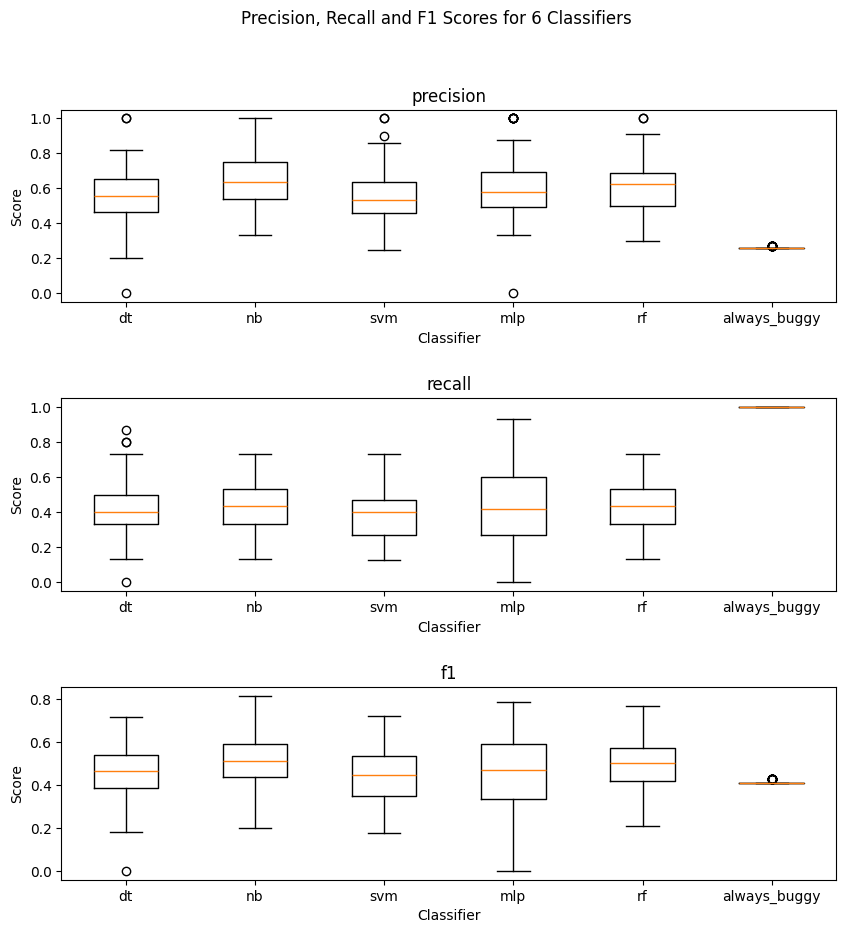

In [19]:
# make a 3 figureas and save them. each of them has 6 box plots for precision, recall and f1 score
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
fig.suptitle('Precision, Recall and F1 Scores for 6 Classifiers')
for i, metric in enumerate(b):
    data = []
    for algo in a:
        data.append(summary[algo][metric])
    axs[i].boxplot(data)
    axs[i].set_title(metric)
    axs[i].set_xticklabels(a)
    axs[i].set_ylabel('Score')
    axs[i].set_xlabel('Classifier')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('../generated/boxplots.png')
plt.show()


In [49]:
import pickle

with open('../generated/classification_results.pkl', 'wb') as f:
    pickle.dump(summary, f)

In [52]:
# sanity check
print(len(summary['dt']['precision']))

100


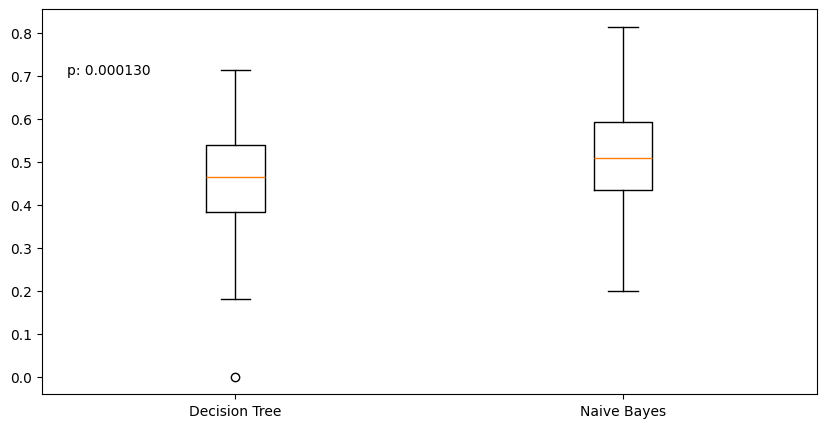

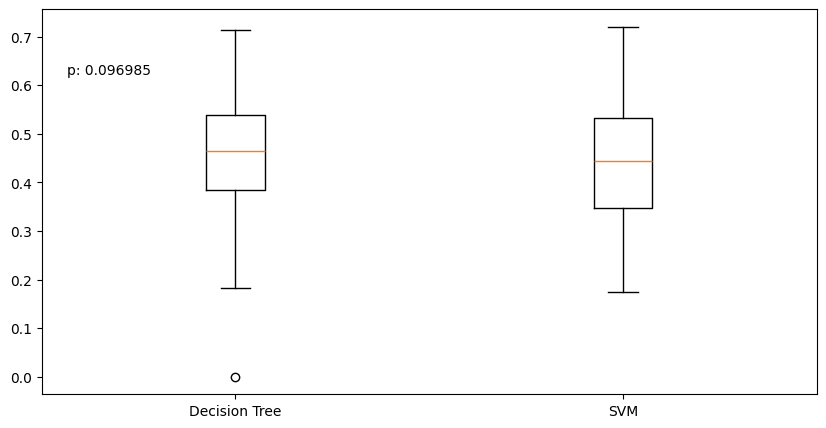

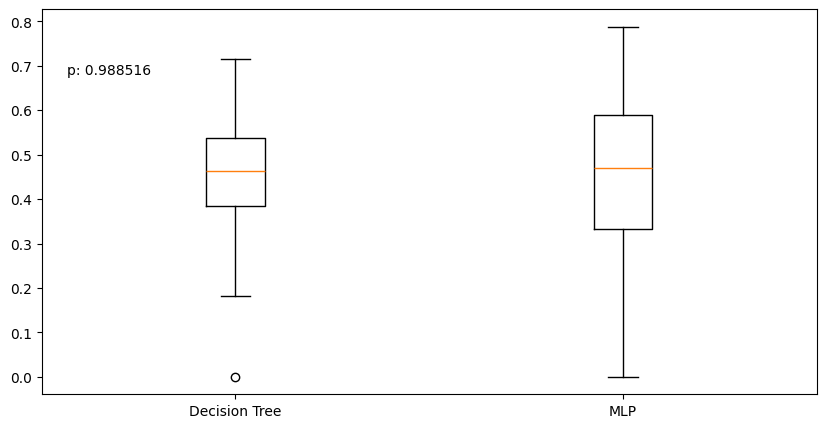

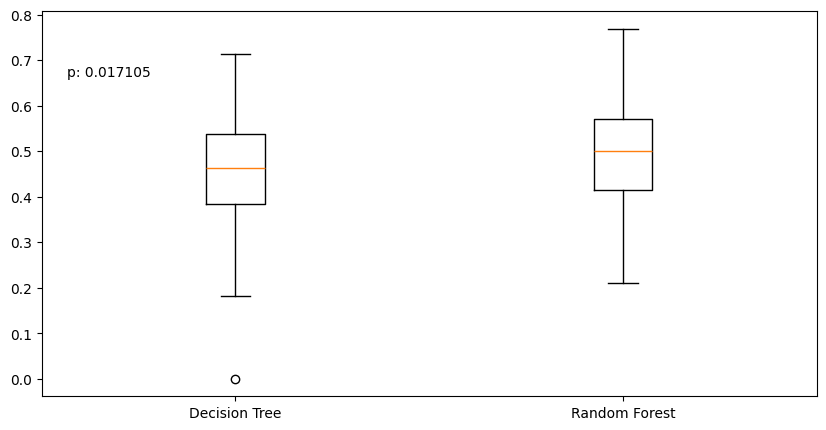

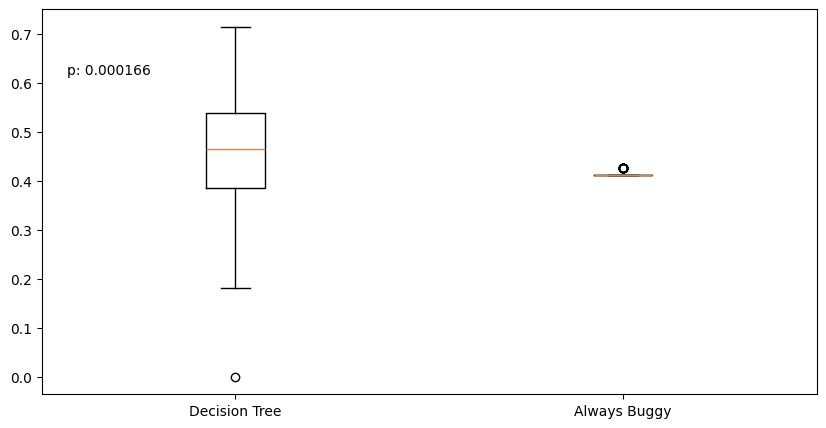

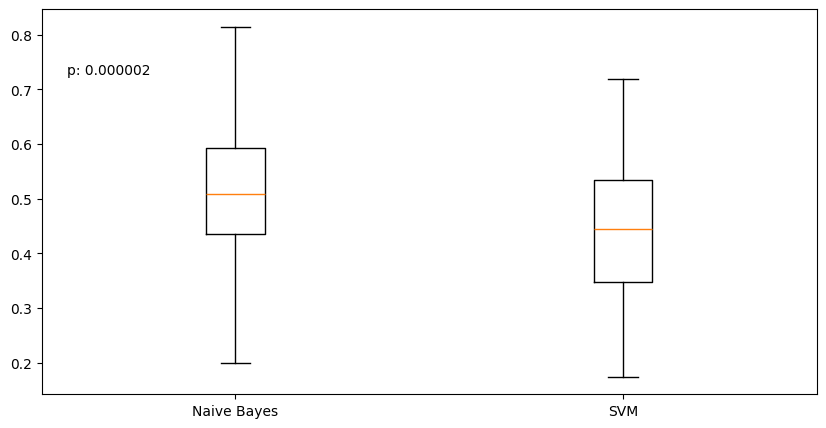

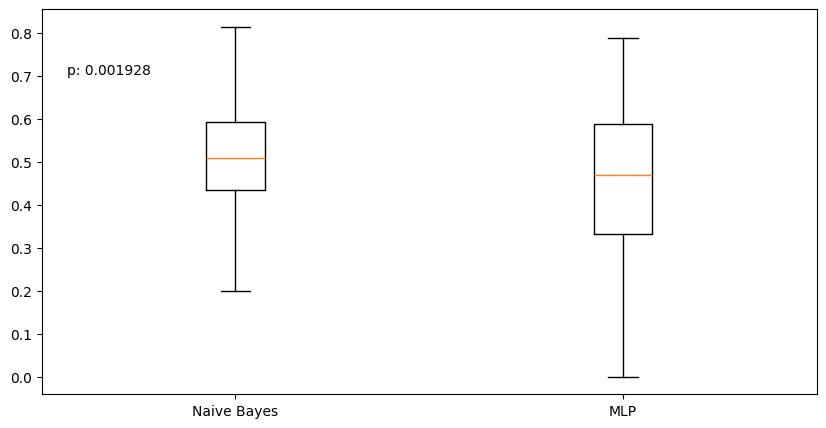

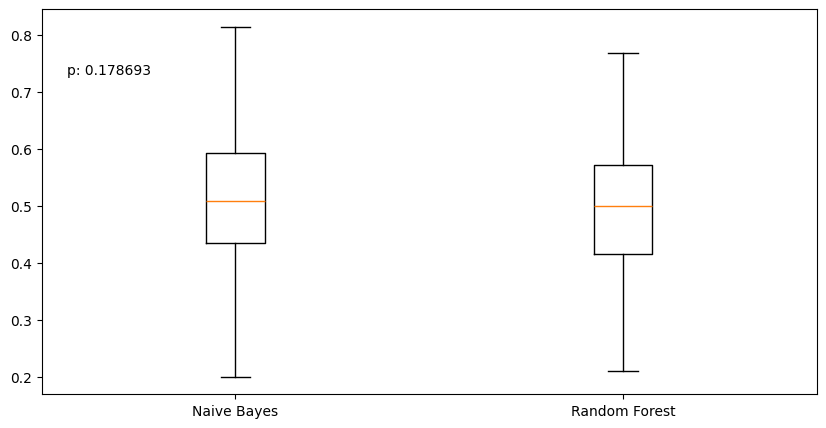

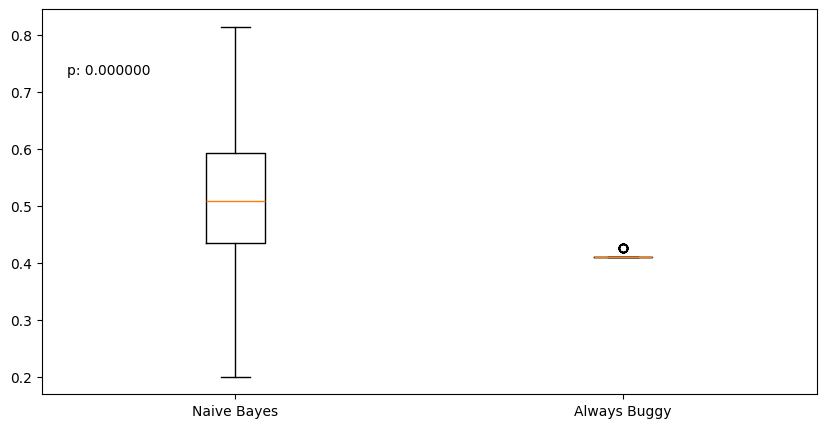

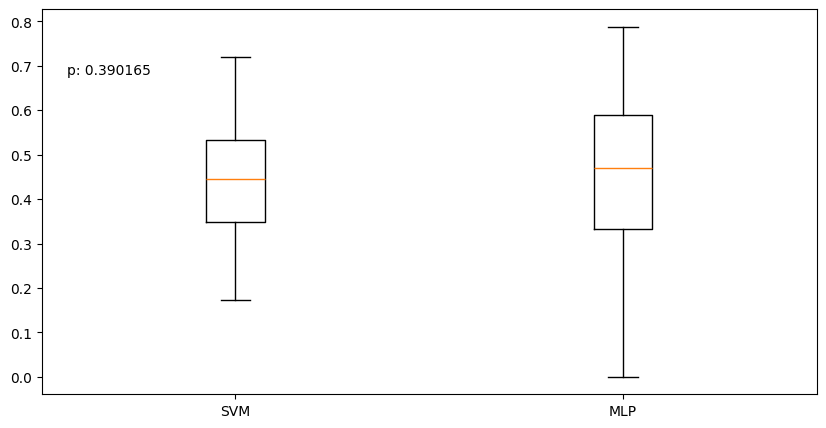

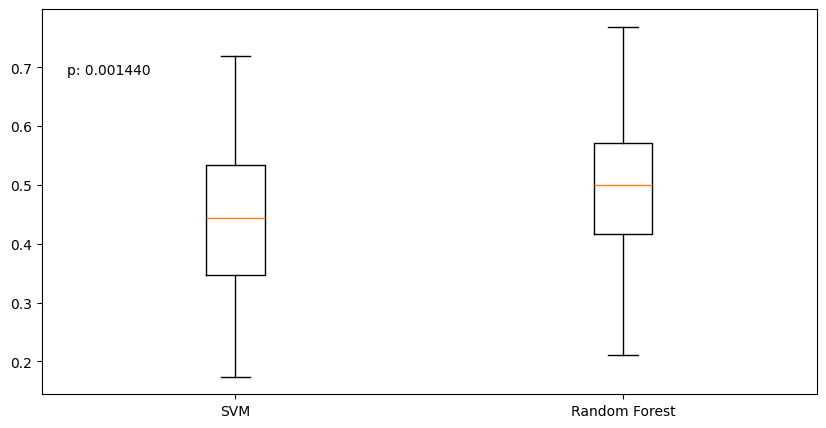

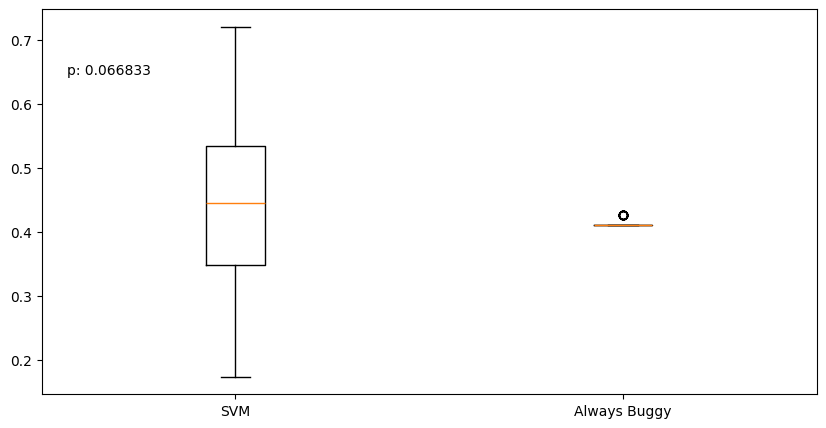

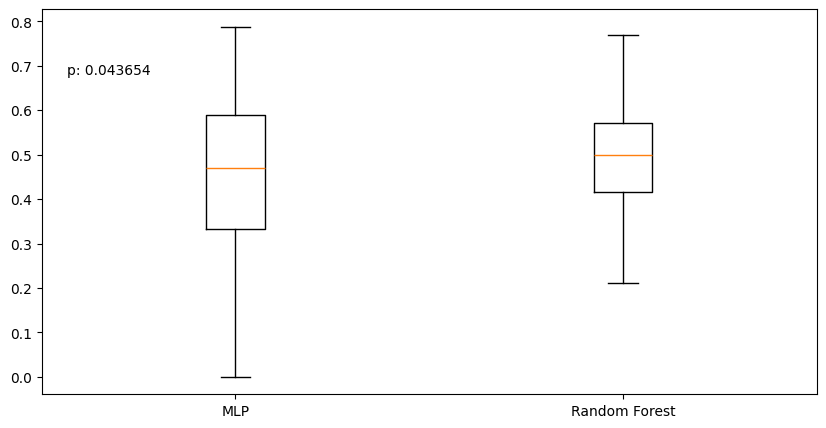

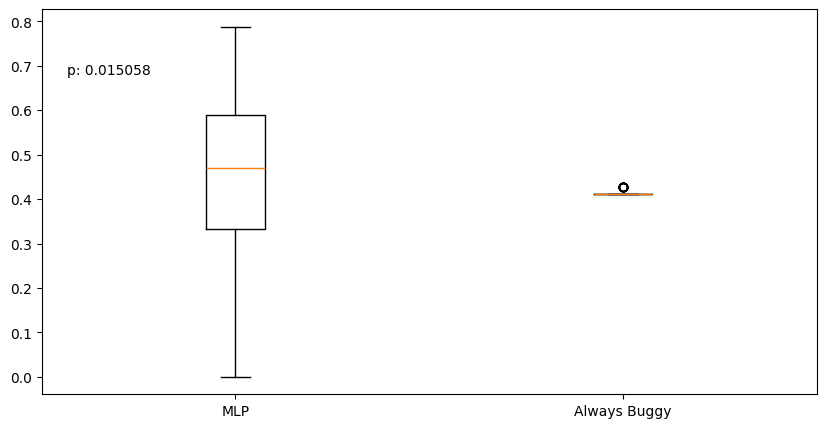

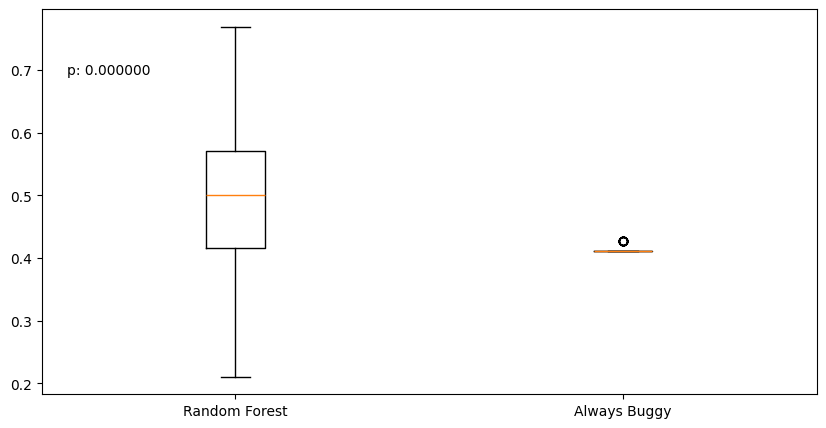

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import numpy as np

def compare_dists(values1, values2, name1, name2, save=False):
    stat, p = wilcoxon(values1, values2)
    fig = plt.figure(figsize =(10, 5))
    plt.boxplot([values1, values2])
    plt.xticks([1, 2], [name1, name2])
    #plt.figtext(0.15, 0.8, f'stat: {stat:.2f}')
    plt.figtext(0.15, 0.75, f'p: {p:.6f}')
    if save:
        plt.savefig(f'../generated/{name1}_{name2}.png')
    plt.show()
    return [np.mean(values1), np.std(values1)], [np.mean(values2), np.std(values2)], p

name_map = {
    'dt': 'Decision Tree',
    'nb': 'Naive Bayes',
    'svm': 'SVM',
    'mlp': 'MLP',
    'rf': 'Random Forest',
    'always_buggy': 'Always Buggy'
}

name_map_inverse = {v: k for k,v in name_map.items()}

keys = list(summary.keys())
info = {
    'pvals': {}
}
df = pd.DataFrame(columns=['method','Decision Tree', 'Naive Bayes', 'SVM', 'MLP', 'Random Forest', 'Always Buggy'])
df['method'] = ['Decision Tree', 'Naive Bayes', 'SVM', 'MLP', 'Random Forest', 'Always Buggy']

df2 = pd.DataFrame(columns=['metric','Decision Tree', 'Naive Bayes', 'SVM', 'MLP', 'Random Forest', 'Always Buggy'])
df2['metric'] = ['f1 mean','f1 std', 'precision mean', 'precision std', 'recall mean', 'recall std']

for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        a,b,c = compare_dists(summary[keys[i]]['f1'], summary[keys[j]]['f1'], name_map[keys[i]], name_map[keys[j]], save=True)
        row = name_map[keys[i]]
        column = name_map[keys[j]]
        df.loc[df['method'] == row, column] = c
        df2.loc[df2['metric'] == 'f1 mean', row] = a[0]
        df2.loc[df2['metric'] == 'f1 mean', column] = b[0]
        df2.loc[df2['metric'] == 'f1 std', row] = a[1]
        df2.loc[df2['metric'] == 'f1 std', column] = b[1]
        df2.loc[df2['metric'] == 'precision mean', row] = np.mean(summary[keys[i]]['precision'])
        df2.loc[df2['metric'] == 'precision mean', column] = np.mean(summary[keys[j]]['precision'])
        df2.loc[df2['metric'] == 'precision std', row] = np.std(summary[keys[i]]['precision'])
        df2.loc[df2['metric'] == 'precision std', column] = np.std(summary[keys[j]]['precision'])
        df2.loc[df2['metric'] == 'recall mean', row] = np.mean(summary[keys[i]]['recall'])
        df2.loc[df2['metric'] == 'recall mean', column] = np.mean(summary[keys[j]]['recall'])
        df2.loc[df2['metric'] == 'recall std', row] = np.std(summary[keys[i]]['recall'])
        df2.loc[df2['metric'] == 'recall std', column] = np.std(summary[keys[j]]['recall'])


In [73]:
df

,method,Decision Tree,Naive Bayes,SVM,MLP,Random Forest,Always Buggy
0,Decision Tree,NaN,0.025004,0.000118,0.944062,0.093184,0.000002
1,Naive Bayes,NaN,NaN,0.0,0.041169,0.292752,0.0
2,SVM,NaN,NaN,NaN,0.000607,0.000001,0.272696
3,MLP,NaN,NaN,NaN,NaN,0.214035,0.000578
4,Random Forest,NaN,NaN,NaN,NaN,NaN,0.0
5,Always Buggy,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
df.drop(columns=['Decision Tree'], inplace=True)
df

,method,Naive Bayes,SVM,MLP,Random Forest,Always Buggy
0,Decision Tree,0.025004,0.000118,0.944062,0.093184,0.000002
1,Naive Bayes,NaN,0.0,0.041169,0.292752,0.0
2,SVM,NaN,NaN,0.000607,0.000001,0.272696
3,MLP,NaN,NaN,NaN,0.214035,0.000578
4,Random Forest,NaN,NaN,NaN,NaN,0.0
5,Always Buggy,NaN,NaN,NaN,NaN,NaN


In [25]:
df2

,metric,Decision Tree,Naive Bayes,SVM,MLP,Random Forest,Always Buggy
0,f1 mean,0.460854,0.512582,0.436686,0.451467,0.49421,0.4141
1,f1 std,0.123348,0.115593,0.118886,0.161733,0.121723,0.006283
2,precision mean,0.554474,0.643369,0.551581,0.599379,0.603918,0.261134
3,precision std,0.151186,0.143019,0.15168,0.179501,0.139632,0.005026
4,recall mean,0.413875,0.435625,0.384625,0.419125,0.434792,1.0
5,recall std,0.147362,0.115565,0.138379,0.213742,0.133223,0.0


In [69]:
with open('../generated/comparison_info.pkl', 'wb') as f:
    pickle.dump(info, f)

In [76]:
df.to_csv('../generated/pvalues.csv', index=False)
df2.to_csv('../generated/f1_mean_std.csv', index=False)

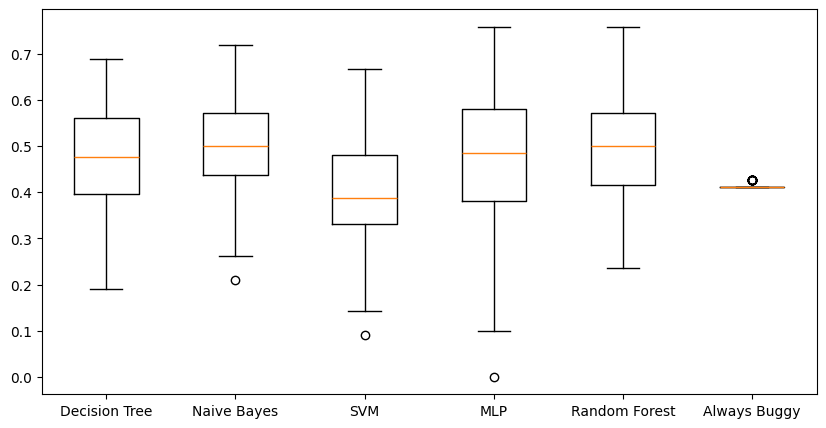

In [78]:
# use df boxplot to compare the classifiers
fig = plt.figure(figsize=(10, 5))
plt.boxplot([summary['dt']['f1'], summary['nb']['f1'], summary['svm']['f1'], summary['mlp']['f1'], summary['rf']['f1'], summary['always_buggy']['f1']])
plt.xticks([1, 2, 3, 4, 5, 6], ['Decision Tree', 'Naive Bayes', 'SVM', 'MLP', 'Random Forest', 'Always Buggy'])
plt.savefig('../generated/classifier_comparison.png')
plt.show()